In [1]:
# removes annoying deprecation warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import pandas as pd
from google.cloud import bigquery
from bq_helper import BigQueryHelper #third party library to translate google query data to dataframe
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style
style.use('ggplot')
import os, sys

sys.path.insert(0, './../utils/')

# custom files 
import random_forest_regressor as rfr
import utilities as util
import validation as cv

from sklearn.model_selection import train_test_split
from sklearn import cross_validation
%matplotlib inline

with open('../../key.txt') as f:
    content = f.readlines()

#add your own key here 
os.environ['GOOGLE_APPLICATION_CREDENTIALS']= content[0]

/home/kristina/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
EPA_QUERY = """
        SELECT
            avg(arithmetic_mean) as am,
            cast(EXTRACT(YEAR FROM SO2_daily.date_local)*10000 +
            EXTRACT(MONTH FROM SO2_daily.date_local)*100 + 
            EXTRACT(DAY FROM SO2_daily.date_local) as string) as date
        FROM
          `bigquery-public-data.epa_historical_air_quality.so2_daily_summary` as SO2_daily
        WHERE EXTRACT(YEAR FROM  SO2_daily.date_local) < 2010 AND state_name ="California" AND city_name="San Francisco"
        GROUP BY date
        ORDER BY date DESC
        """

bq_assistant_SO2 = BigQueryHelper("bigquery-public-data", "epa_historical_air_quality")
df_SO2 = bq_assistant_SO2.query_to_pandas(EPA_QUERY)

In [3]:
df_SO2.head()

,am,date
0,4.256493,20081231
1,1.904546,20081230
2,3.388961,20081229
3,1.360390,20081228
4,1.183766,20081227


In [4]:
SF_CRIME_QUERY = """
        SELECT
            COUNT( DISTINCT unique_key) as count,
            cast(EXTRACT(YEAR FROM SFCrimeData.timestamp)*10000 +
            EXTRACT(MONTH FROM SFCrimeData.timestamp)*100 + 
            EXTRACT(DAY FROM SFCrimeData.timestamp) as string) as date
        FROM
          `bigquery-public-data.san_francisco_sfpd_incidents.sfpd_incidents` AS SFCrimeData
        WHERE category != "NON-CRIMINAL" AND category != "RECOVERED VEHICLE"
        GROUP BY date
        ORDER BY date DESC
        """

bq_assistant_SF_crime = BigQueryHelper("bigquery-public-data", "san_francisco_sfpd_incidents.sfpd_incidents")
df_SF_crime = bq_assistant_SF_crime.query_to_pandas(SF_CRIME_QUERY)

In [5]:
df_SF_crime.head(n=10)

,count,date
0,5,20180515
1,48,20180514
2,92,20180513
3,110,20180512
4,128,20180511
5,154,20180510
6,190,20180509
7,192,20180508
8,167,20180507
9,191,20180506


In [6]:
df_SF_census = pd.read_csv('../../data/censuspopulationsf.tsv', sep='\t', header=None)
df_SF_census.columns = ['year', 'pop']
df_SF_census.head(n=20)

,year,pop
0,2003,757638
1,2004,750133
2,2005,748846
3,2006,751431
4,2007,758348
5,2008,767067
6,2009,774347
7,2010,805770
8,2011,816294
9,2012,830406


In [7]:
# make column for counts per capita
util.per_capita(df_SF_crime, df_SF_census)
# merge SO2 and Crime data
df_merged = util.merge_data(df_SO2, df_SF_crime)
df_merged['per_capita'] *=100000
df_merged.head()

,am,date,count,per_capita
3421,4.256493,20081231,260,33.895344
3422,1.904546,20081230,270,35.199011
3423,3.388961,20081229,258,33.634611
3424,1.360390,20081228,236,30.766543
3425,1.183766,20081227,266,34.677544


In [8]:
# find optimum regressor
regr = rfr.find_regressor(df_merged[['date','am']].as_matrix(), df_merged['per_capita'].values)
regr

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/kristina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


[CV] n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True 
[CV] n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True 
[CV] n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True 
[CV] n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True 
[CV]  n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True, total=   1.1s
[CV] n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True 
[CV]  n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True, total=   1.2s
[CV] n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True 
[CV]  n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True, total=   1.2s
[CV] n_estimators=250, min_samples_split=2, max_depth=10, bootstrap=False 
[CV]  n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True, total=   1.5s
[CV] n_estimators=250, min_samples_split=2, max_depth=10, bootstrap=False 
[CV]  n_estimators=275, min_samples_split=4, max_d

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=225, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [9]:
# split dataset 
X_train, X_test, y_train, y_test = train_test_split(df_merged[['date','am']], df_merged['per_capita'].values, test_size=0.33, shuffle=False, stratify=None)
# make predictions based on optimum regressor
y_pred = rfr.fit_and_predict(regr, X_train, X_test, y_train, y_test)

./../utils/random_forest_regressor.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  regr.fit(X_train.as_matrix(), y_train)
./../utils/random_forest_regressor.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return regr.predict(X_test.as_matrix())


In [10]:
cv.MSE(y_test, y_pred)

175.89498077568814

In [11]:
# 10 fold tss cross validation
tss_score = cv.Cross_Validation(df_merged[['date','am']], df_merged['per_capita'], regr, 10)
print('10-fold cross validation using time series split (additive): {} '.format(tss_score))

10-fold cross validation using time series split (additive): 22.258009718778613 


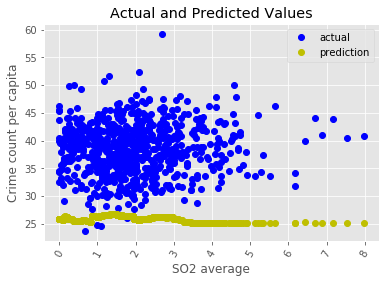

In [12]:
plt.plot(X_test['am'], y_test, 'bo', label = 'actual')
plt.plot(X_test['am'], y_pred, 'yo', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
plt.xlabel('SO2 average'); plt.ylabel('Crime count per capita'); plt.title('Actual and Predicted Values');

In [13]:
df_merged.corr()

,am,count,per_capita
am,1.000000,0.075994,0.083013
count,0.075994,1.000000,0.997524
per_capita,0.083013,0.997524,1.000000


Text(0.5,1,'Predicted crime per capita')

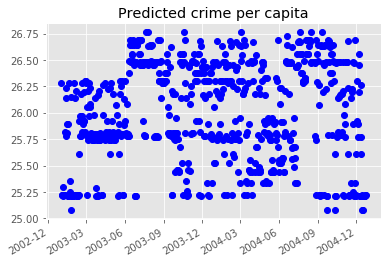

In [14]:
X_test['formatted_date'] = pd.to_datetime(X_test['date'], format='%Y%m%d')
# plot original data 
fig, ax = plt.subplots()
ax.plot(X_test['formatted_date'], y_pred, 'bo')
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
# n = 10
# [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
ax.set_title('Predicted crime per capita')

Text(0.5,1,'Residual plot')

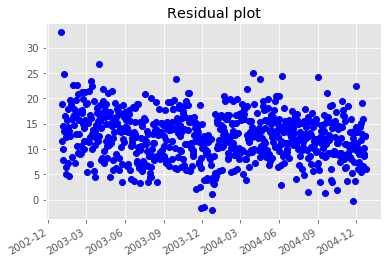

In [15]:
residuals = y_test - y_pred
fig, ax = plt.subplots()
ax.plot(X_test['formatted_date'], residuals, 'bo')
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
# n = 10
# [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
ax.set_title('Residual plot')